In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [25]:
# Загружаем данные. Датасеты Train и Теst не будем объединять, а будем работать с каждым отдельно для избежания "выучивания" признаков алгоритмом
root_path = "/kaggle/input/sf-dst-scoring/"

df_train = pd.read_csv(f"{root_path}train.csv")
df_test = pd.read_csv(f"{root_path}test.csv")


In [26]:
# Посмотрим на df_train датасет
df_train.info()

# Видно что в колонке education есть пропуски, которые чуть позже заполним

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [27]:
#Посмотрим что из себя представляют данные в датасете
df_train.head()

# Исходя из увиденного, можно сделать вывод, что колонку app_date нужно привести к date формату и попробовать извлечь из этого какую-то пользу. 
# Например разбить значения колонки на три отдельных колонки: день, месяц и год, возможно поэксперементировать с переводом значений из числовых 
# в категориальные признаки

# колонку client_id скорее всего будем игнорировать при создании и обучении модели, но будем использовать ее при загрузке результата работы на Kaggle
# На первый взгляд видно, что в датасете существует много бинарных признаков, кроме того многие из числовых значений лучше себя покажут 
# в виде категориальных, но более точные выводы сделаем после визуализации данных

# Многие эксперименты с данными будут производиться для улучшения метрик модели, по этому можно будет в коде встретить разные експерименты с 
# данными, например разбиение даты на отдельные колонки и перевод месяцев в категориальные признаки, так как это улучшает наш roc_auc_score
# То есть будем манипулировать данными работая исключительно на roc_auc_score метрику, а потом увидим оправдает ли этот подход наши ожидания 
# на тестовых данных

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [28]:
# посмотрим на тестовый датасет
df_test.info()
df_test.head()

# Выводы все те же, что и по трейн датасету: пропуски в education, те же операции с app_date  колонкой, тот же формат остальных данных. 
# Соответсвенно методы работы с test датасетом будут аналогичны методам работы с train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [29]:
# Перед визуализацией данных поработаем с  колонкой app_date. Для этого приведем ее к date формату а так же разделим на колонки: день и месяц,

dates = pd.to_datetime(df_train.app_date, format="%d%b%Y")
df_train['app_month'] = dates.dt.month
df_train['app_day'] = dates.dt.day
df_train['app_weekday'] = dates.dt.dayofweek


# Проверим количество признаков относящихся к году
print(dates.dt.year.value_counts())

# Все значения относятся к 2014-му году. Нет смысла добавлять, его в качестве отдельной колонки, т.к. он в будущем не окажет никакого
# положительного действия на метрики модели

2014    73799
Name: app_date, dtype: int64


In [30]:
# Проверим, какие данные из датасета являются бинарными

for col in df_train.columns:
    if df_train[col].nunique() <= 2:
        print(col, " " * (20 - len(col)), df_train[col].nunique())

sex                   2
car                   2
car_type              2
good_work             2
foreign_passport      2
default               2


In [31]:
# Проверим, какие данные из датасета являются категориальными

for col in df_train.columns:
    if 2 < df_train[col].nunique() <= 10:
        print(col, " " * (20 - len(col)), df_train[col].nunique())

education             5
region_rating         7
home_address          3
work_address          3
sna                   4
first_time            4
app_month             4
app_weekday           7


In [32]:
# Разделим предварительно наши данные на бинарные, категориальные и числовые. Делить будем на трейн сете, но это же разделение будет в будущем
# работать и на тестовых данных
def data_sort(data):
    bin_cols = list()
    cat_cols = list()
    num_cols = list()

    for col in data.drop(['client_id', 'default'], axis=1).columns:
        if data[col].nunique() <= 2:
            bin_cols.append(col)

        elif 2 < data[col].nunique() <= 10:
            cat_cols.append(col)

        elif data[col].nunique() > 10 and data[col].dtype in ["int64", "float64"]:
            num_cols.append(col)

    return bin_cols, cat_cols, num_cols

bin_cols, cat_cols, num_cols = data_sort(df_train)

# **Визуализация Данных**

<AxesSubplot:>

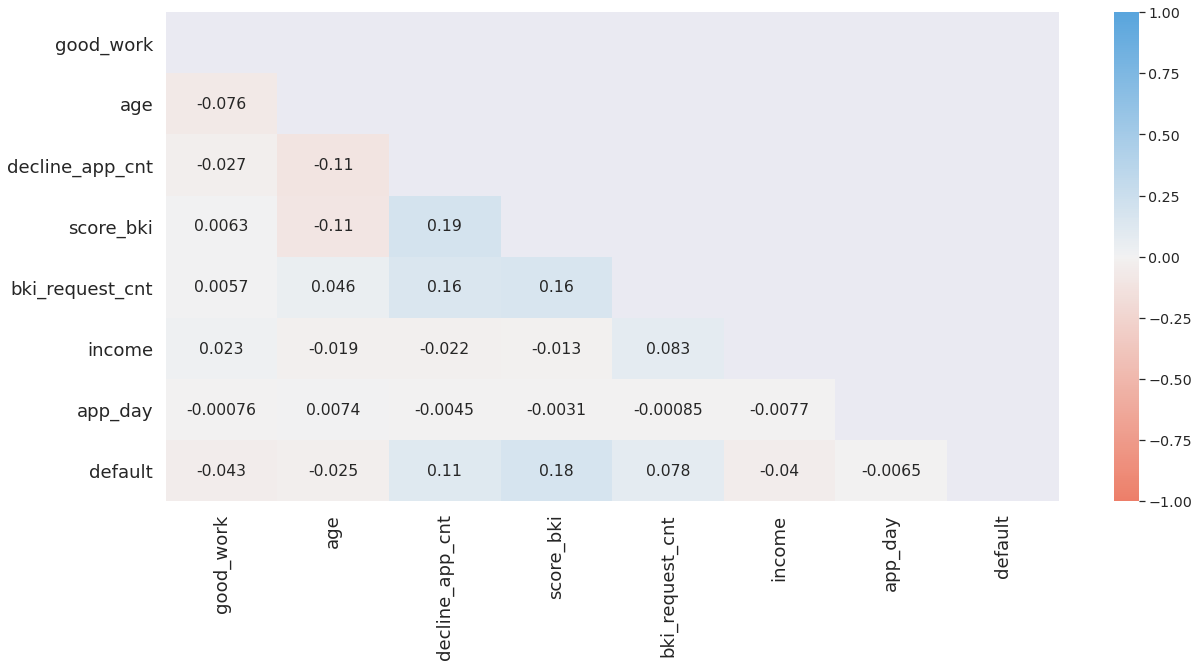

In [33]:
# Посмотрим на корреляцию бинарных и числовых признаков датасета с целевой переменной
corrmat = df_train[bin_cols + num_cols + ["default"]].corr()

f, ax = plt.subplots(figsize=(20,9))

colormap =  sns.diverging_palette(20, 240, l=65, as_cmap=True)
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.3)
sns.heatmap(corrmat, mask=mask, vmax=1, vmin=-1, annot=True, center=0, cmap=colormap)

Выводы из таблицы. Корреляция признаков с default очень слабая, наиболее высокая корреляция наблюдается у признаков score_bki, и decline_app_cnt - 0.18 и 0.11 cоответственно. Оставим все признаки и не будем их удалять в связи сильной корреляцией, т.к. сильной корреляции (>0.8) здесь нет

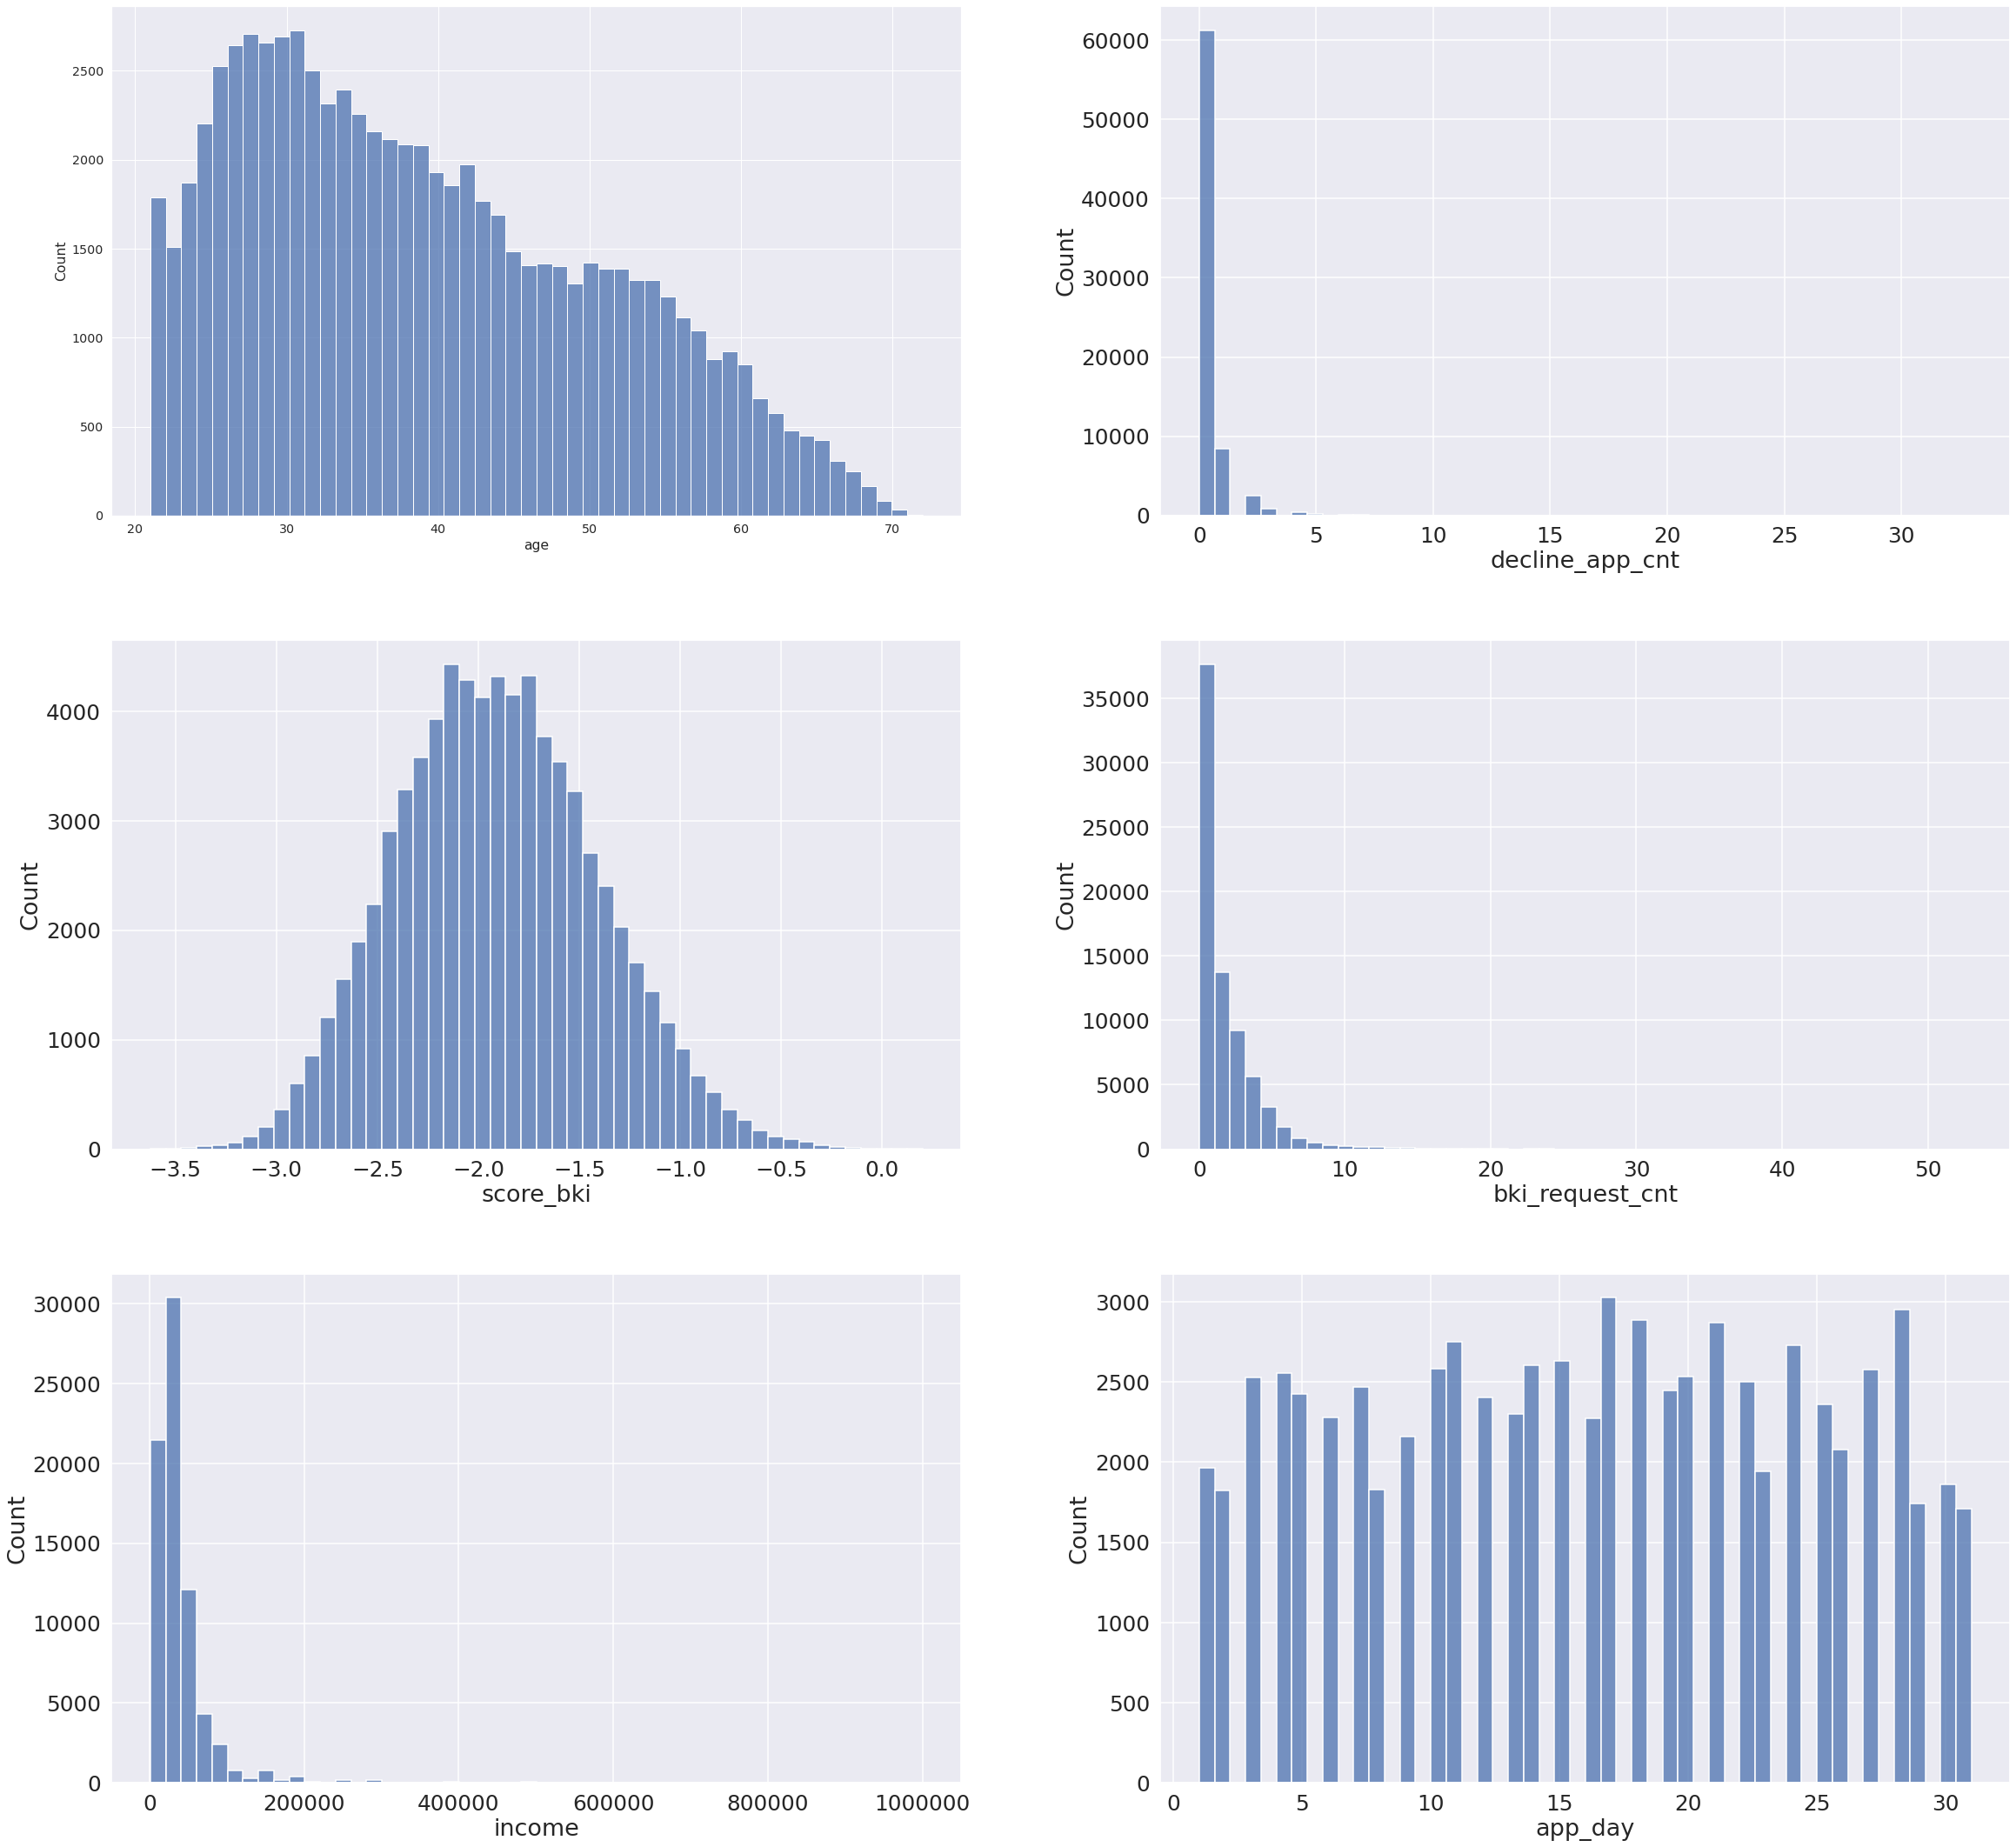

In [34]:
# Распределение числовых признаков
def num_data_visualisation(data_frame, columns, log_data=False):
    sns.set_style('darkgrid')
    
    fig = plt.figure(figsize=(35,50))
       
    for it, value in enumerate(columns):
        plt.subplot(4,2,it+1)
        ax = plt.gca()
        ax.get_xaxis().get_major_formatter().set_scientific(False)

        # логарифмируем, если включен флаг log_data
        data = np.log(data_frame[data_frame[value] > 0][value]) if log_data else data_frame[value]
        
        sns.histplot(data, cbar=True, bins = 50)
        fig.tight_layout(pad=4.0)
        sns.set_context('talk',font_scale=1.5)
    
    fig.subplots_adjust(top=0.8)
    
num_data_visualisation(df_train, num_cols)       

Судя по графикам значения score_bki и app_day распределены более менее равномерно и не требуют логарифмирования в то время как age, income и bki_request_cnt должны быть прологарифмированы, для визуализации равномерного распределения. Судя по графикам наиболее встречающийся возраст запрашивающих кредит 28-31. Судя по распределению дней, можно заметить равномерные колебания на протяжении месяца, вполне вероятно, что количеств запросов зависит от дня недели, что мы увидим чуть позже, т.к. наш код дни недели отнес в категориальные признаки. График income показывает, что наиобольшая часть дохода составляет в пределах 30 к рублей.



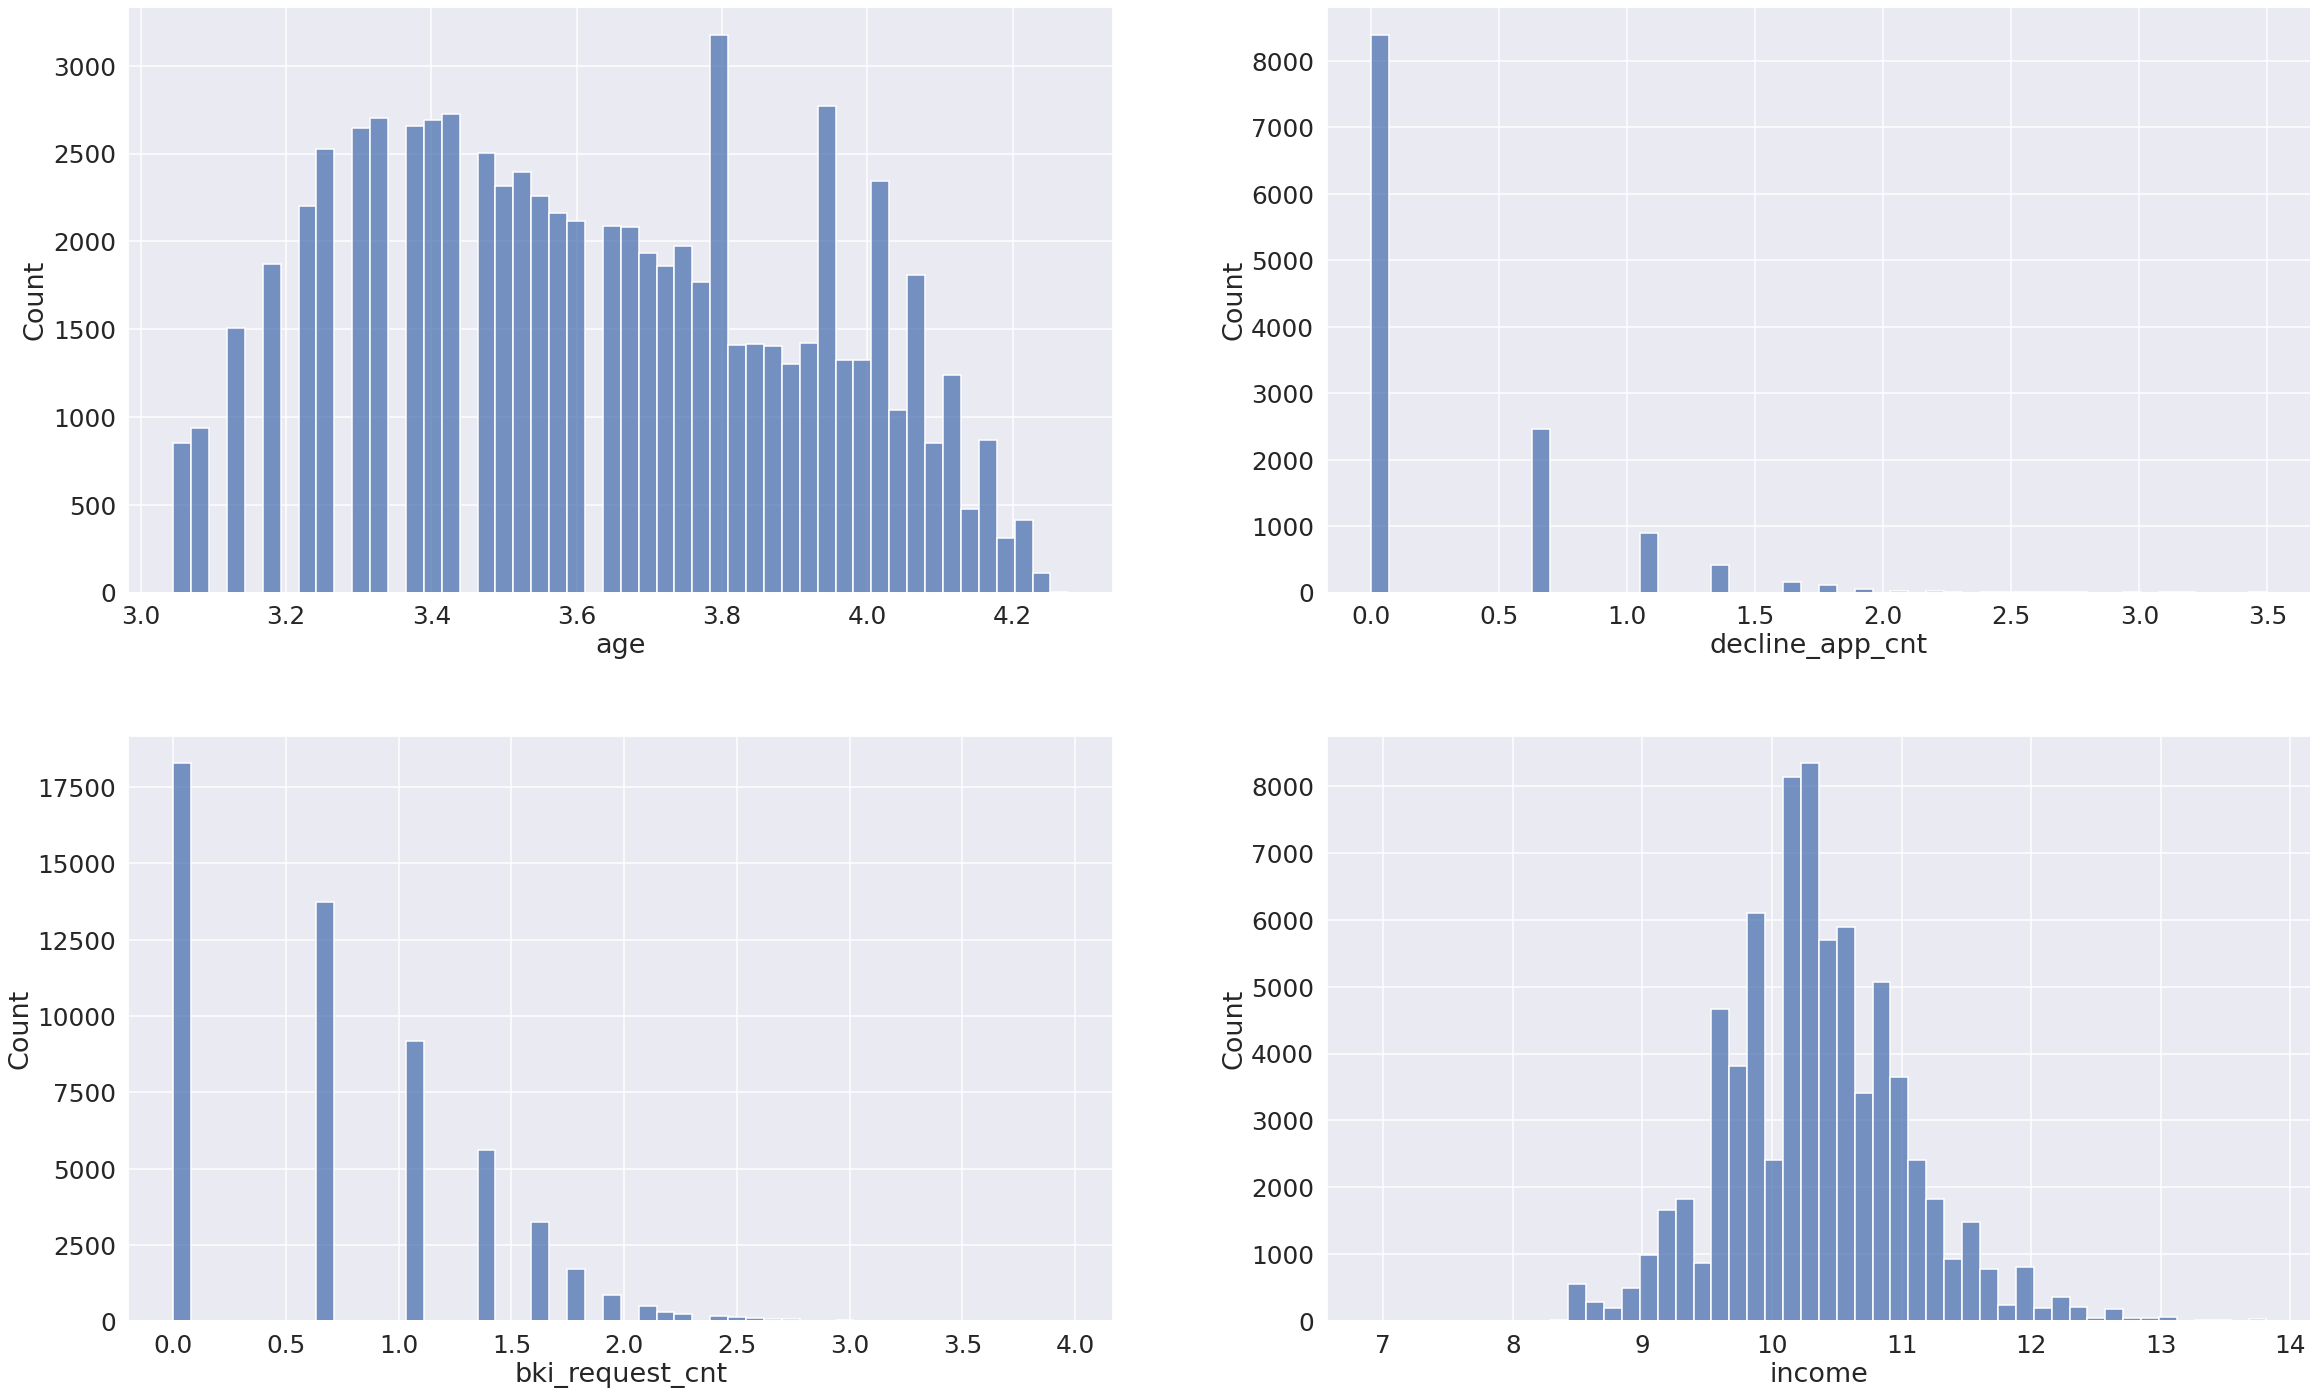

In [35]:
# Как видим значения age, income и bki_request_cnt распределены неравномерно, по этому вполне логично неравномерные значения прологарифмировать
num_data_visualisation(df_train, columns=[x for x in num_cols if x not in  ['score_bki', 'app_day']], log_data=True)

После логарифмирования значения age и income выглядять более равномерно распределеннымим. При обработке данных колонкам age и income присвоим их прологарифмированные значение, т.к. это улучшит значение roc_auc_score(спойлер), в то время как логарифирование bki_request_cnt не даст улучшение метрик

<AxesSubplot:>

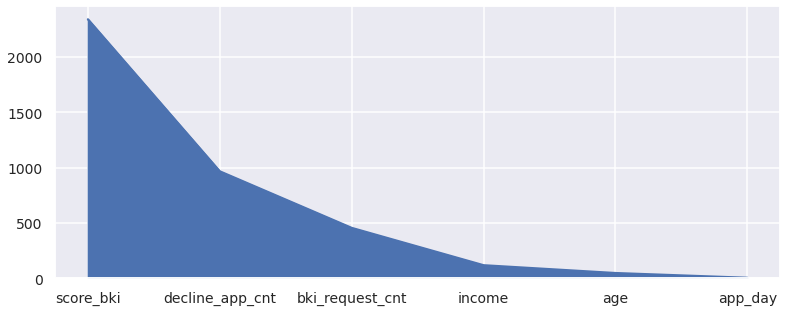

In [36]:
# Посмотрим на значимость числовых данных для нашей целевой переменной
num_weights = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0], index=num_cols)
num_weights.sort_values(ascending=False, inplace=True)
num_weights.plot(kind='area', figsize=(13, 5), fontsize=14)

Как видно из графика наиболее значимым для целевой переменной 'default' является score_bki и самым менее значимым - app_day. Но не будем удалять app_day из датасета, т.к. хоть и незначительно, но он улучшить нашу метрику модели в будущем

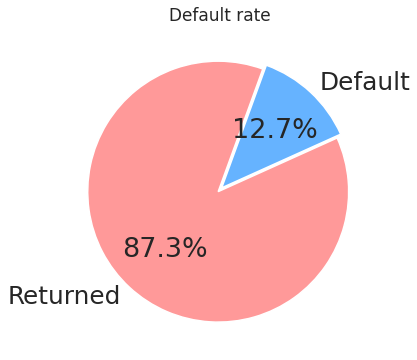

In [37]:
# Посмотрим соотношение тех кто не отдал кредит к добросовестным заемщикам
default_data = df_train.groupby('default')['default'].count()
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=default_data, 
        autopct='%.1f%%', 
        explode=[0.02]*2, 
        labels=['Returned', 'Default'], 
        pctdistance=0.6, 
        startangle=70,
        colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title("Default rate", fontsize=17);

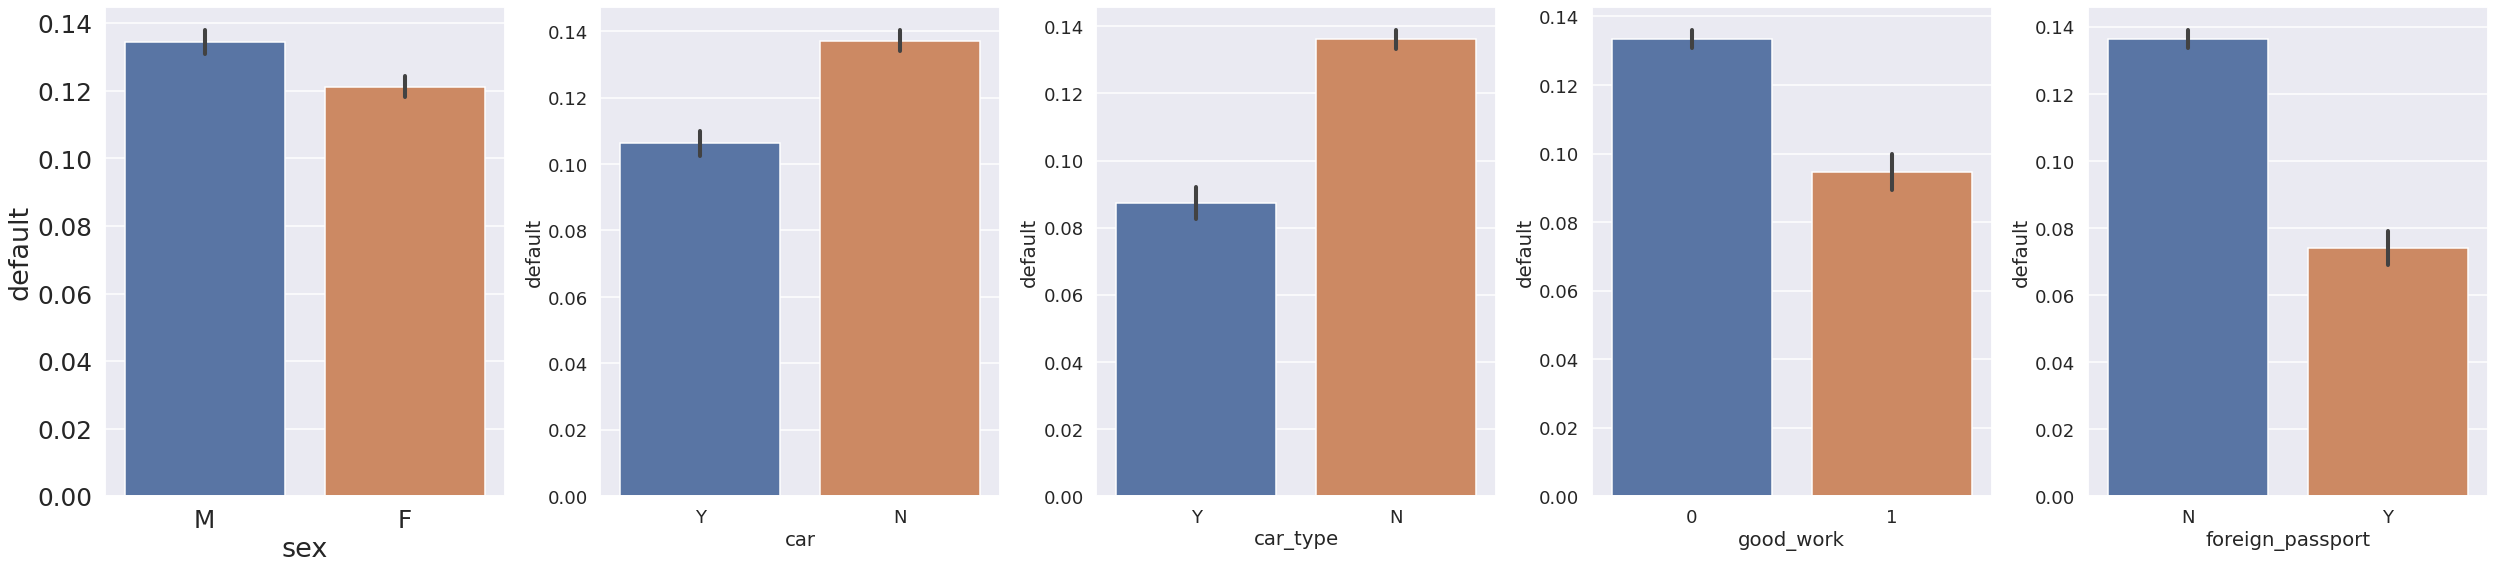

In [38]:
# Посмотрим соотношение бинарных признаков к целевой переменной

def features_relation(data_frame, columns):
    sns.set_style('darkgrid')
    
    fig = plt.figure(figsize=(35,10))
       
    for it, value in enumerate(columns):
        plt.subplot(1,len(columns),it+1)
        sns.barplot(x=value, y="default", data=data_frame[[value, 'default']])
        fig.tight_layout(pad=1.0)
        sns.set_context('talk',font_scale=1.1)
    
    fig.subplots_adjust(top=0.8)

features_relation(df_train, bin_cols)

Как видим из соотношения бинарных признаков к целевой переменной основную долю людей не возвращающих заём являются мужчины без автомобиля и хорошей работы , не имеющие загранпаспорт

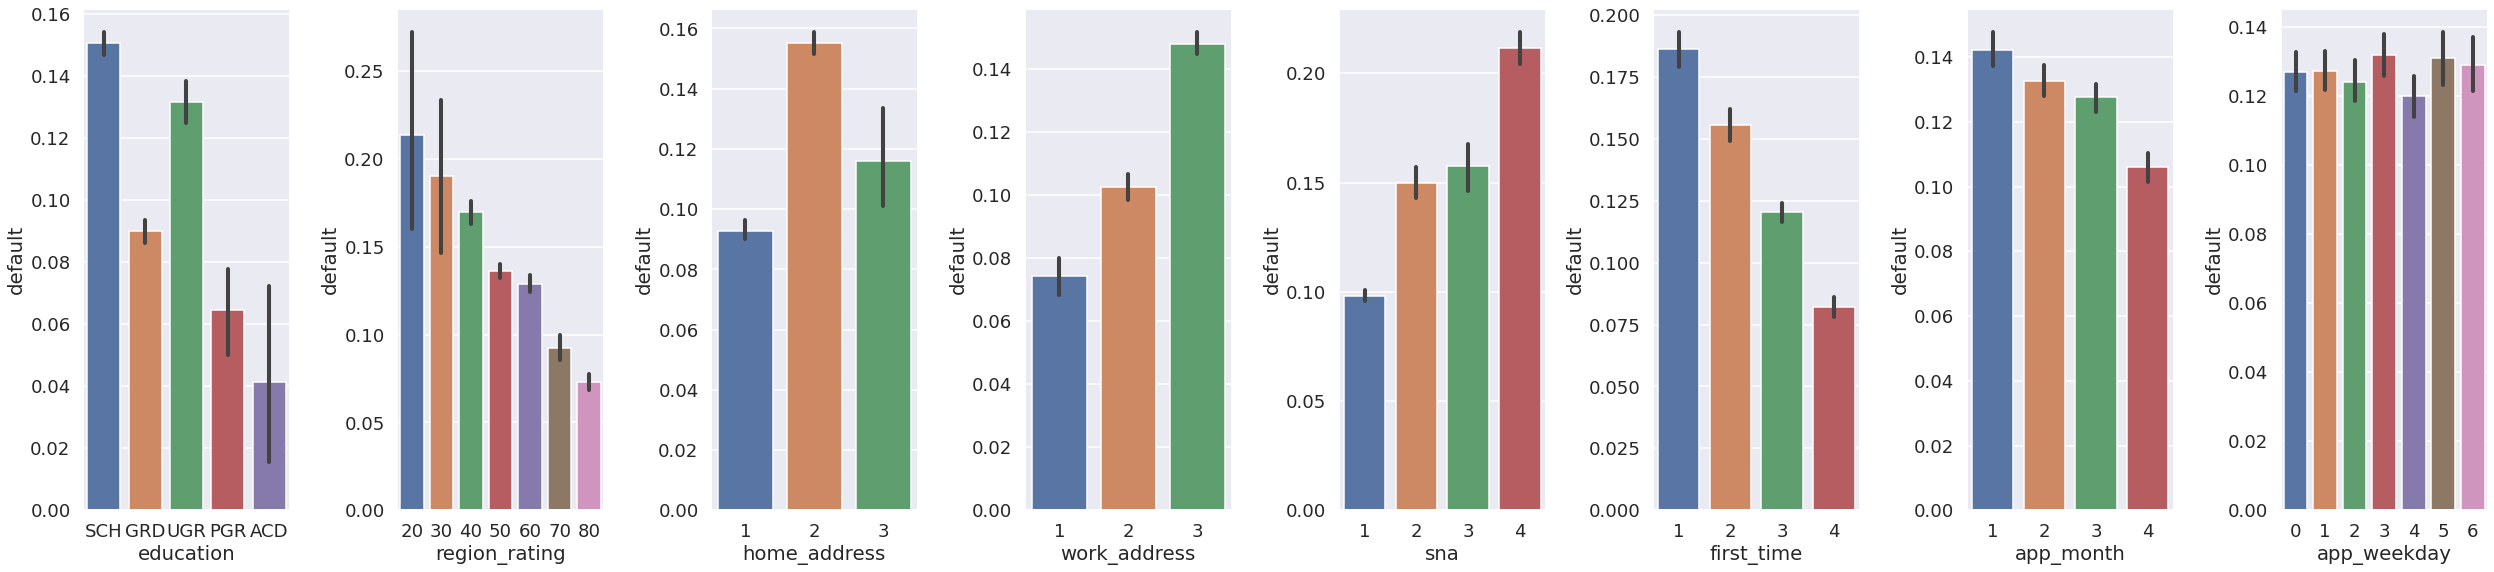

In [39]:
# Посмотрим соотношение категориальных признаков к целевой переменной
features_relation(df_train, cat_cols)

Сложно сделать какую-то полную картину на основании данных соотношения категориальных признаков к целевой переменной, но в некоторых моментах вполне явно прослеживаются конкретные тенденции. Например что люди со образованием SCH и UGR наиболее часто не возвращают кредиты или люди, из региона с рейтингом 20.


# Feature Engineering

Поскольку два датасета train и test не объединяли в один, то работа с признаками будет идти для каждого отдельного датасета. При этом train датасет разделим для обучения и проверки метрик модели, а предсказывать отдельно будем на  test датасете



In [40]:
# Добавим пару функций которые помогут перевести числовые признаки в категориальные разделив их на квантили 25, 50, 75 и присвоив каждой группе
# свой Лейбл

# Ф-ция  которая проверяя вхождение значения val в определенную группу из набора limits присваивает ей соотвествующий маркер из labels
def cats_create(val, limits, labels):
    for it, value in enumerate(limits):
        if val < limits[it]:
            return labels[it]
    else:
        return labels[-1]


# Разделяем числовой признак на квантили и используем ф-цию cats_create для создания категориальных признаков. Функция намеренно ничего 
# не возвращает т.к. в этом нет обходимости. Датасет будет изменен без возврата значения

def num_to_cat_by_quantilles(data, source_column, destination_column, limits=[25, 50, 75]):
    firts_limit, second_limit, third_limit = np.percentile(data[source_column], limits)
    data[destination_column] = data[source_column].apply(cats_create, args=([firts_limit, second_limit, third_limit], ['A', 'B', 'C', 'D']))

In [41]:
# Список числовых признаков, которые будут переводится в категориальные. 
# Второе значение во вложенных списках - название нового признака, который будет создан

new_categories = [['income', 'income_groups'], ['score_bki', 'score_bki_rate'], ['age', 'age_groups'],
                  ['bki_request_cnt', 'bki_request_cnt_groups']]

# Добавим новые признаки в категориальный список
for x in new_categories:
    cat_cols.append(x[1])

In [42]:
# Выделим целевую переменную из train датасета
Y = df_train['default']
df_train.drop(['default'], axis=1, inplace=True)

In [43]:
def predict_engine():
    # Предопределим модель и гиперпараметры для модели
    # Добавим типы регуляризации
    penalty = ['l1','l2']


    # Вариаинты испаользованных значений гиперпараметров для улучшения метрик модели представлены ниже и закомментированы. Экспериментальным путем 
    # выяснилось, что значение 0.01 показывает максимальный результат roc_auc_score. По этому удалил все остальные значения для экономии времени, 
    # т.к. на работу модели учитывая количество всех признаков и количества гиперпараметров уходило много времени - вплоть до 2-3 минут.

    # C = np.logspace(0, 4, 10)
    # C = [0.01, 0.1, 1, 100, 1000]
    # C = [0.05, 0.15, 0.3, 0.5]


    # Создадим гиперпараметры. 
    hyperparameters = dict(C=[0.01], penalty=penalty)

    model = LogisticRegression(random_state=0, max_iter=1000, solver='liblinear')

    # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
    return GridSearchCV(model, hyperparameters, cv=5, verbose=0)



In [44]:
# Займемся созданием новых признаков для обоих датасетов
processed_data = dict()
train_set_size = df_train.shape[0]

hardcoded_num_cols = num_cols.copy()
for obj in [df_train, df_test]:

    # Заполняем пропуски в колонке education
    obj.education.fillna("SCH", inplace=True)

    # создаем новые категориальные признаки на основе числовых
    for it in new_categories:
        num_to_cat_by_quantilles(obj, it[0], it[1])


    # Логарифмируем доход и возраст    
    obj['income']= np.log(obj['income'])
    obj['age']= np.log(obj['age'])

    # Добавим колонку date в test датасет, т.к. для train мы добавили ранее для визуализации признаков
    if obj.shape[0] < train_set_size:
        dates = pd.to_datetime(obj.app_date, format="%d%b%Y")
        obj['app_month'] = dates.dt.month
        obj['app_day'] = dates.dt.day
        obj['app_weekday'] = dates.dt.dayofweek
        

    # Удалим  колонку app_date        
    obj.drop(['app_date'], axis=1, inplace=True)
    
    # Создадим бинарный признак на основе регионов
    obj['region_groups'] = obj.region_rating.apply(lambda x: 1 if x <= 40 else 0)
    
    # Создадим категориальный признак на основе значения decline_app_cnt
    obj.decline_app_cnt = obj.decline_app_cnt.apply(lambda x: x if x <= 2 else 2)
    
    # Поекспериментируем с комбинациями  существуюищих параметров и созданием на основе них новых признаков
    obj['address_rate'] = obj.home_address * obj.work_address
    obj['sna_rate'] = obj.sna * obj.first_time
    obj['adress_sna'] = obj.address_rate * obj.sna_rate

    
    # Создадим новые полиномиальные числовые признаки
    pf = PolynomialFeatures()
    new_data = pf.fit_transform(obj[hardcoded_num_cols])[:, len(hardcoded_num_cols) + 1:]
    pf_columns = pf.get_feature_names()[len(hardcoded_num_cols) + 1 :]
    
    # добавляем новые полиномиальные значения к датасету
    obj = pd.concat([obj, pd.DataFrame(new_data, columns=pf_columns)], axis=1)
    
    # добавим названия полиномиальных признаков в список числовых
    if obj.shape[0] == train_set_size:
        num_cols.extend(pf_columns)
        
        # добавим имя параметра region_groups в список бинарных
        bin_cols.append('region_groups')
        
        # добавим  названия новых экспериментальных признаков в список числовых
        for col in ['address_rate', 'sna_rate', 'adress_sna']:
            num_cols.append(col)
        


    # Нормализуем числовые признаки, а также создадим новые dummy переменные из категориальных и бинарных признаков
    label_encoder = LabelEncoder()

    
    for column in bin_cols:
        obj[column] = label_encoder.fit_transform(obj[column])
   
    X_cat = OneHotEncoder(sparse=False).fit_transform(obj[cat_cols].values)
    X_bin = OneHotEncoder(sparse=False).fit_transform(obj[bin_cols].values)
    X_num = StandardScaler().fit_transform(obj[num_cols].values)

    
    # Сохраним обработанные данные в словарь для последующей работы с моделью
    dataset_type = 'train' if obj.shape[0] == train_set_size else 'test'
    processed_data[dataset_type] = np.hstack([X_cat, X_bin, X_num])     

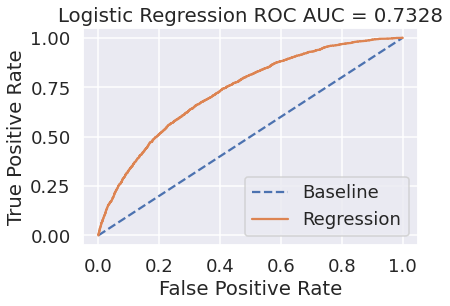

In [45]:
# Функция оценки качества работы модели
def model_scoring(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc_score(y_test, probs))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    
# обучим модель на train сете, предварительно разделив его  для использования метрик. Это разделение и обучение используется исключительно
# для приблизительного замера модели с помощью roc_auc_score и сonfusion matrix. Для итогового результата train датасет делить не будем
X_train, X_test, Y_train, Y_test = train_test_split(processed_data['train'], Y, test_size=0.2)
clf = predict_engine()
clf.fit(X_train, Y_train)
Y_pred = clf.predict_proba(X_test)[:, 1]
Y_pred_values = clf.predict(X_test)

model_scoring(Y_test, Y_pred)


<AxesSubplot:>

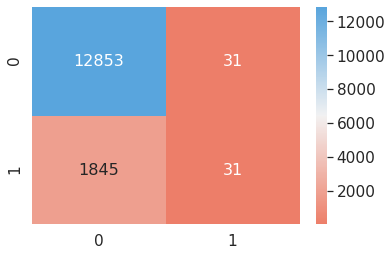

In [46]:
# Посмотрим на результат тренировки модели спомощью Confusion Matrix
conf_mat = confusion_matrix(Y_test, Y_pred_values)

sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap=colormap)

In [47]:
# Теперь создадим новую модель и обучим ее на полном train датасете
clf = predict_engine()
clf.fit(processed_data['train'], Y)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=0,
                                          solver='liblinear'),
             param_grid={'C': [0.01], 'penalty': ['l1', 'l2']})

In [48]:
# предскажем данные на тестовой модели и подготовим данные для Leaderboard
df_test['default'] = clf.predict_proba(processed_data['test'])[:, 1]
submission = df_test[['client_id', 'default']]
submission.to_csv("submission.csv", index=False)